# Chargement et échantillonnage

In [ ]:
import os

FILE_PATH = r'C:\Users\lucie\OneDrive\Documents\SEMESTRE_6\S6C01-test\data\yelp_academic_reviews4students.jsonl'

if os.path.exists(FILE_PATH):
    print(f"Fichier trouvé. Taille : {round(os.path.getsize(FILE_PATH)/1024/1024, 2)} Mo")
else:
    print("ERREUR : Le fichier n'existe pas au chemin indiqué.")
    
# Compter les lignes (1 ligne = 1 avis JSON)
with open(FILE_PATH, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f)

print("Nombre de lignes (avis) :", n_lines)

Fichier trouvé. Taille : 719.56 Mo
Nombre de lignes (avis) : 1000000


In [ ]:
import pandas as pd

df_review = pd.read_json(FILE_PATH, lines=True)
df_sample = df_review.sample(n = 50000, random_state = 42) 
print(f"Nombre de lignes dans df_sample : {len(df_sample)} avis")

Nombre de lignes dans df_sample : 50000 avis


# Pré traitement

In [ ]:
import pandas as pd

df = df_sample[["review_id", "business_id", "stars", "text"]].copy()
df = df.dropna(subset=["text", "stars"]).reset_index(drop=True)

print("Shape:", df.shape)
df.head(10)

Shape: (50000, 4)


,review_id,business_id,stars,text
0,0ON6ABIpqg8FiHt53Dj31g,5rScKeYVjFk8VahsvJv9QA,1,i have been going to this place for decades. ...
1,pR_sndks4v_uLsyu43NSxw,HF4Oh0KDTYo6xvf_JCoybQ,5,Beautiful. .yes..a little pricey. .yes...but d...
2,ljM-FhhKoL2v9Vki_a-A9Q,AFYI0sfZ6WdVELjjEYOIpw,2,The rides are fun and its cool to see the anim...
3,H-GyUI__-_-cXE02h52rrA,_vLfidpLDYHfZ_KnFZ75Lg,1,literally the guy that is running the place is...
4,gDgnJE3-a0FiE0VXZQ27iA,whiNQ0Z2AUkyBKucejQNTA,5,My husband and I adore this restaurant. Every ...
5,UxYKyB5wS3zFUloaEmWihw,Y2Pfil51rNvTd_lFHwzb_g,4,Looking for a beignet fix without the wait? C...
6,6FjXoLln2BzduHHZ0XV8_w,HaSCfbMg9CKMlrBV0sZjoA,4,The food was great. I loved the crawfish and ...
7,EeAKEoh4Qpr1QlOlHamycA,wPcspvYuIWBihFGOupEuLg,1,Called to have ac cleaned because cold air was...
8,FtJK4RuynpBhD7RgrdApBw,qjIN4UbE96Cq6JKwLIQ9VQ,1,I was the first people there in an EMPTY early...
9,oJ5uIB1K7TZtJ6dNiqtPDw,QcuTCSfnI6WqKpuDL_a0OA,5,Great spot to pick up some spices in Downtown ...


## Polarité des scores

In [5]:
score = df["stars"].value_counts(normalize=True)
print("Distribution des classes :")
print(score.map('{:.4f}'.format))

Distribution des classes :
stars
5    0.4620
4    0.2082
1    0.1555
3    0.0974
2    0.0769
Name: proportion, dtype: object


In [ ]:
import re
from langdetect import detect, LangDetectException

def stars_polarity(score):
    if score > 3: return "positif"
    elif score < 3: return "négatif"
    else: return "neutre"

# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Application sur le dataframe
print("Détection de la langue en cours (ça peut prendre quelques secondes)...")
df['lang'] = df['text'].apply(detect_language)

# Filtrage : On ne garde que l'anglais ('en')
print(f"Avant filtrage : {len(df)} avis")
df = df[df['lang'] == 'en'].reset_index(drop=True)
print(f"Après filtrage (Anglais uniquement) : {len(df)} avis")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)       # enlever liens
    text = re.sub(r"[^a-z\s']", " ", text)     # garder lettres
    text = re.sub(r"\s+", " ", text).strip()   # espaces propres
    return text

print("Nettoyage des textes et création des labels...")
df["label"] = df["stars"].apply(stars_polarity)
df["text_clean"] = df["text"].astype(str).apply(clean_text)

df[["stars", "label", "text_clean"]].head(10)

Détection de la langue en cours (ça peut prendre quelques secondes)...
Avant filtrage : 50000 avis
Après filtrage (Anglais uniquement) : 49952 avis
Nettoyage des textes et création des labels...


,stars,label,text_clean
0,1,négatif,i have been going to this place for decades i ...
1,5,positif,beautiful yes a little pricey yes but damn it ...
2,2,négatif,the rides are fun and its cool to see the anim...
3,1,négatif,literally the guy that is running the place is...
4,5,positif,my husband and i adore this restaurant every t...
5,4,positif,looking for a beignet fix without the wait caf...
6,4,positif,the food was great i loved the crawfish and mu...
7,1,négatif,called to have ac cleaned because cold air was...
8,1,négatif,i was the first people there in an empty early...
9,5,positif,great spot to pick up some spices in downtown ...


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["stars_encoded"] = le.fit_transform(df["stars"])

NUM_CLASSES = len(le.classes_)
print("Classes :", dict(zip(le.classes_, le.transform(le.classes_))))

Classes : {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4)}


In [ ]:
from sklearn.model_selection import train_test_split

X = df['text_clean']
y = df['stars_encoded']

# Découpage Entraînement / Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Répartition des notes (Rating) en % :")

rating_pct = df['stars_encoded'].value_counts(normalize=True).sort_index() * 100
print(rating_pct.map('{:.2f}%'.format))

Répartition des notes (Rating) en % :
stars_encoded
0    15.55%
1     7.69%
2     9.74%
3    20.82%
4    46.19%
Name: proportion, dtype: object


Les représentations de texte comme tf-idf , bm25 et sac de mots ne marchent pas avec une architecture CNN standard a la place j'utilise des tokenizer + embedding (transforme) pour :
- Le modèle ne sait pas lire des mots ("Food", "Bad"). Il ne comprend que des chiffres
- Le Tokenizer sert à construire un dictionnaire numéroté unique à ton dataset

------

EX: 
- Phrase : "The food was good"
- Sortie du Tokenizer : [1, 25, 12, 42]

------

### Tokenizer : Met les mots dans l'ordre et leur donne un numéro.

### Embedding : Donne du sens aux mots en les transformant en coordonnées mathématiques intelligentes.

------

- CNN : Il a besoin de lire la séquence pour appliquer ses filtres (ses "lunettes")
- BoW / BM25 / TF-IDF : Ce sont des méthodes "Bag of Words". Elles mélangent tous les mots dans un sac

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight


MAX_WORDS = 10000
MAX_LEN = 100

print("Tokenisation des textes pour le CNN")
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_raw) # On apprend le vocabulaire sur le train

# Transformation du texte en suites de chiffres
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Padding (Toutes les phrases doivent faire la même longueur)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"Dimension des données CNN : {X_train_pad.shape}")

# Calcul des poids (toujours important)
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

Tokenisation des textes pour le CNN
Dimension des données CNN : (39961, 100)


In [ ]:
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

model_cnn = Sequential([
    # Couche 1 : Embedding (Transforme les chiffres en vecteurs de sens)
    Embedding(input_dim=MAX_WORDS, output_dim=50, input_length=MAX_LEN),
    
    # Couche 2 : Convolution 1D - partie lecture
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    
    # Pour réduire un peu la taille avant la 2ème lecture
    MaxPooling1D(pool_size=2),
    
    # Bloc Conv 2 (Il relit les motifs trouvés par le Bloc 1)
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    
    # Garde uniquement l'information la plus forte
    GlobalMaxPooling1D(),
    
    # Plus de neurones pour une rélfexion plus large
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Couche 3 : Dense (Classification) - partie reflexion
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(NUM_CLASSES, activation='softmax')
])

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

c:\Users\lucie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    restore_best_weights=True
)

print("\nDébut de l'entraînement du CNN")
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10, 
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Début de l'entraînement du CNN
Epoch 1/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4677 - loss: 1.2927 - val_accuracy: 0.5853 - val_loss: 1.0212
Epoch 2/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6193 - loss: 0.9935 - val_accuracy: 0.6159 - val_loss: 0.9109
Epoch 3/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6669 - loss: 0.8603 - val_accuracy: 0.6024 - val_loss: 0.9559
Epoch 4/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7107 - loss: 0.7188 - val_accuracy: 0.6147 - val_loss: 0.9664
Epoch 5/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7490 - loss: 0.6002 - val_accuracy: 0.5911 - val_loss: 1.1448


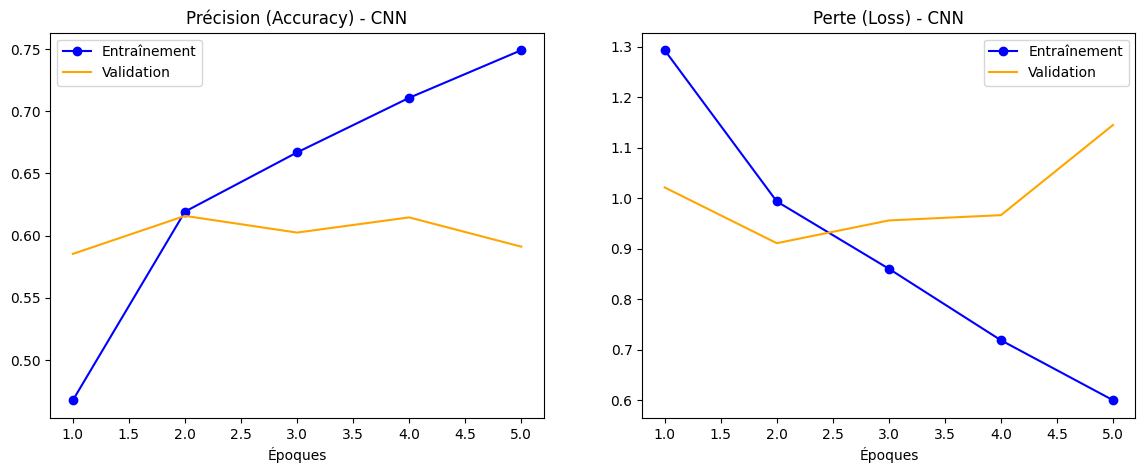


--- Evaluation Finale CNN ---


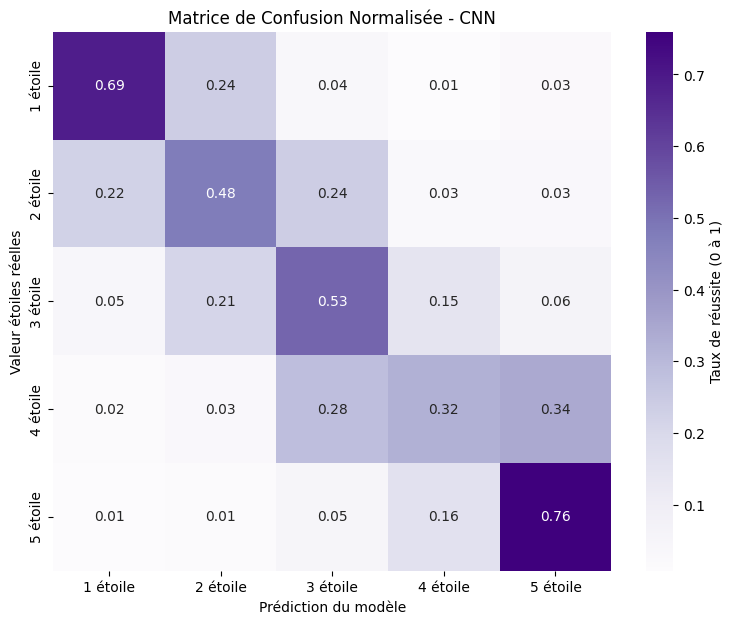

Précision (Accuracy) : 0.6159
F1-Score (Ajusté selon la quantité d'avis par étoile) : 0.6239
Perte (Log Loss)     : 0.9109

Rapport détaillé :
              precision    recall  f1-score   support

    1 étoile       0.78      0.69      0.73      1527
    2 étoile       0.34      0.48      0.40       764
    3 étoile       0.31      0.53      0.39       917
    4 étoile       0.42      0.32      0.36      2065
    5 étoile       0.81      0.76      0.78      4718

    accuracy                           0.62      9991
   macro avg       0.53      0.56      0.53      9991
weighted avg       0.64      0.62      0.62      9991



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns


acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Entraînement')
plt.plot(epochs_range, val_acc, 'orange', label='Validation')
plt.title('Précision (Accuracy) - CNN')
plt.xlabel('Époques')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Entraînement')
plt.plot(epochs_range, val_loss, 'orange', label='Validation')
plt.title('Perte (Loss) - CNN')
plt.xlabel('Époques')
plt.legend()
plt.show()

print("\n--- Evaluation Finale CNN ---")

# Matrice de Confusion (Corrélation)
y_pred_probs = model_cnn.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = [f"{star} étoile" for star in le.classes_]

plt.figure(figsize=(9, 7))
sns.heatmap(cm_norm, 
            annot=True, 
            fmt='.2f', 
            cmap='Purples',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Taux de réussite (0 à 1)'})

plt.title('Matrice de Confusion Normalisée - CNN')
plt.xlabel('Prédiction du modèle')
plt.ylabel('Valeur étoiles réelles')
plt.show()

# Calcul des métriques spécifiques au CNN
acc_cnn = accuracy_score(y_test, y_pred)
f1_cnn = f1_score(y_test, y_pred, average='weighted')
loss_cnn = log_loss(y_test, y_pred_probs)


print(f"Précision (Accuracy) : {acc_cnn:.4f}")
print(f"F1-Score (Ajusté selon la quantité d'avis par étoile) : {f1_cnn:.4f}")
print(f"Perte (Log Loss)     : {loss_cnn:.4f}")

print("\nRapport détaillé :")
print(classification_report(y_test, y_pred, target_names=class_names))

## Test phrase

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Fonction adaptée pour le CNN
def predict_custom_sentence_cnn(text, model, tokenizer, stars_encoder, max_len=100):
    # Nettoyage (Le même que pour l'entraînement)
    text_clean = clean_text(text)
    # Transformation (Texte -> Séquence d'entiers)
    seq = tokenizer.texts_to_sequences([text_clean])
    # Padding (Ajout de zéros pour atteindre 100 mots)
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    # Prédiction
    prediction_probs = model.predict(padded, verbose=0)
    # Décodage
    predicted_index = np.argmax(prediction_probs)
    predicted_stars = stars_encoder.inverse_transform([predicted_index])[0]
    
    print(f"Phrase : \"{text}\"")
    print(f"Prédiction des étoiles : {predicted_stars}")
    print(f"Confiance : {prediction_probs[0][predicted_index]:.2f}")
    print("-" * 30)

# --- ZONE DE TEST ---
phrases_a_tester = [
    "The food was amazing and the service was perfect!", 
    "It was terrible, I will never come back.", 
    "The food was okay but a bit expensive.", 
    "I don't know what to think about this place." 
]

print("--- TEST DU MODÈLE CNN ---\n")
for phrase in phrases_a_tester:
    predict_custom_sentence_cnn(phrase, model_cnn, tokenizer, le)

--- TEST DU MODÈLE CNN ---

Phrase : "The food was amazing and the service was perfect!"
Sentiment prédit : POSITIF
Confiance : 99.31%
------------------------------
Phrase : "It was terrible, I will never come back."
Sentiment prédit : NÉGATIF
Confiance : 99.99%
------------------------------
Phrase : "The food was okay but a bit expensive."
Sentiment prédit : NEUTRE
Confiance : 94.09%
------------------------------
Phrase : "I don't know what to think about this place."
Sentiment prédit : NÉGATIF
Confiance : 47.66%
------------------------------
